In [8]:
import os
import sys
from glob import glob

import numpy as np
import pandas as pd

import json
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

basic_packages = [os, sys, glob, np, pd, json, cv, Image, plt]
print("Packages Version Infos :")
for pname in basic_packages:
    try:
        print(f"\t{pname.__name__}\t:\t{pname.__version__}")
    except:
        print(f"\tmodule '{pname.__name__}' has no attribute '__version__'")

Packages Version Infos :
	module 'os' has no attribute '__version__'
	module 'sys' has no attribute '__version__'
	module 'glob' has no attribute '__version__'
	numpy	:	1.21.4
	pandas	:	1.3.4
	json	:	2.0.9
	cv2	:	4.5.4
	PIL.Image	:	8.4.0
	module 'matplotlib.pyplot' has no attribute '__version__'


In [9]:
from os.path import split as spt
from os.path import join as jn

# init path
BASE = spt(spt(os.getcwd())[0])[0]
CONF = jn(BASE, "config")
DATA = jn(BASE, "assets/data/plastic-segmentation")

# comp. Train and Test

In [10]:
TRAIN = jn(BASE, "assets/data/plastic-segmentation/Train")
TEST = jn(BASE, "assets/data/plastic-segmentation/Test")

PCLS = []
paths = {"image_path" : [], "annot_path": []}

for fpath in [TRAIN, TEST]:
    kind = os.path.basename(fpath)
    BDIR = sorted(os.listdir(fpath))
    for bdir in BDIR:
        try:
            pcls = str(bdir.lower())
            assert pcls.startswith("p")
            img_path = jn(fpath, bdir)
            img_paths = sorted(glob(img_path + "/*.jpg"))
            (paths['image_path']).extend(img_paths)
            PCLS.append(bdir)
        except:
            for pdir in np.unique(PCLS):
                annot_path = jn(fpath, bdir, pdir)
                annot_path = sorted(glob(annot_path + "/*.json"))
                (paths['annot_path']).extend(annot_path)

In [11]:
kind = pd.Series([fpath.split('/')[-3] for fpath in paths['image_path']], name="kind")
label = pd.Series([fpath.split('/')[-2] for fpath in paths['image_path']], name="label")
metainfo_id = pd.Series([(fpath.split('/')[-1]).split('_')[1] for fpath in paths['image_path']], name="metainfo_id").astype(int)
feats = pd.Series([(fpath.split('/')[-1]).split('_')[2][:-4] for fpath in paths['image_path']], name="feature").astype(int)

baseDF = pd.concat([kind, label, metainfo_id, feats, pd.DataFrame(paths)], axis=1)

In [12]:
print(len(baseDF['metainfo_id'].unique()))

pd.DataFrame(baseDF['metainfo_id'].value_counts().reset_index()).head(20)

44


,index,metainfo_id
0,58,295
1,76,294
2,56,277
3,54,270
4,50,258
5,34,183
6,35,160
7,74,152
8,88,152
9,37,150


In [13]:
baseDF.columns

Index(['kind', 'label', 'metainfo_id', 'feature', 'image_path', 'annot_path'], dtype='object')

In [14]:
pd.DataFrame(baseDF.groupby(["kind", "label", "metainfo_id"])["feature"].value_counts())

feature
kind  label metainfo_id feature         
Test  PE    74          1              1
                        3              1
                        5              1
                        7              1
                        9              1
...                                  ...
Train PS    42          7294           1
                        7482           1
                        7596           1
                        7605           1
                        7734           1

[4400 rows x 1 columns]

In [15]:
cnt = 0
for mid in baseDF['metainfo_id'].unique():
    cnt += 1
    mid_cls = baseDF[baseDF['metainfo_id']==mid]['label'].unique()
    if len(mid_cls)>1:
        print(baseDF[baseDF['metainfo_id']==mid]['label'].unique())
print(cnt)

44


# Comp. Images and Annots

* BBOX 확인 : @qkrwjdduf159 의 이미지 전처리 참고
* segmentation
  * annot_path -> json.loads(~) -> jsd['annotations/annotation']['segmentation'] : [[pts,,,pts]]
  * segmentation의 포인트가 전부 2의 배수인 것을 보면, x,y points가 그들이 어떻게 생성한지 알 수 없는 규칙이지만, 그래도 값은 다 존재함을 알 수 있음.

## way-1 : 위에서 생성한 변수 그대로 사용하는 방법

In [16]:
trnDF = baseDF[baseDF['kind']=='Train']
tstDF = baseDF[baseDF['kind']=='Test']

In [17]:
# example
print(trnDF[trnDF['label']=='PE']['image_path'][0])
print(trnDF[trnDF['label']=='PE']['annot_path'][0])

/Volumes/WORK/Google/Compute-Engine-VM/github-trial/fetched-github-repo/Waste-Recycling-Image-Segmentation/assets/data/plastic-segmentation/Train/PE/PE_074_10.jpg
/Volumes/WORK/Google/Compute-Engine-VM/github-trial/fetched-github-repo/Waste-Recycling-Image-Segmentation/assets/data/plastic-segmentation/Train/annotation/PE/PE_074_10.json


In [54]:
trial_img = trnDF[trnDF['label']=='PE']['image_path'][0]
trial_ant = trnDF[trnDF['label']=='PE']['annot_path'][0]

with open(trial_ant, 'r') as jsf:
    jsd = json.loads(jsf.read())
# 진짜 읽어오는 것 자체는 문제가 없는데, 이들이 general하지 않은 방법으로 json을 작성했거나, 내가 json을 아직 70%도 이해하지 못했거나 무튼 그럼

segmt = []
for obj in range(len(jsd['annotations'])):
    segmt.extend(jsd['annotations'][obj]['segmentation'])
for seg in segmt:
    print(np.array(seg).reshape(2,-1))  # [[x_0,...,x_n-1], [y_0,...,y_n-1]]
    print(np.array(seg).reshape(-1,2))  # [[x_0, y_0],...,[x_n-1,y_n-1]]
    # 각 값이 매칭되는 결과가 다른만큼 검증은 두 차례에 걸쳐서 이루어져야 함

[[ 890  837  883  841  877  847  872  854  868  861  863  868  856  875
   851  881  845  888  842  895  837  902  834  909  830  916  826  923
   822  930  818  937  814  944  809  951  807  958  802  965  800  972
   795  979  793  986  792  993  792 1000  795 1007  802 1011  808 1017
   815 1019  822 1024  829 1028  836 1033  843 1036  850 1041  857 1044
   864 1049  871 1052  878 1056  885 1058  892]
 [1058  899 1054  906 1049  909 1042  914 1035  918 1028  922 1021  924
  1014  930 1007  934 1000  937  993  941  987  945  980  948  973  952
   966  957  959  960  952  964  945  966  938  966  931  967  924  968
   917  970  910  974  903  980  896  983  889  982  882  977  876  970
   874  964  869  957  867  950  865  944  860  937  858  931  854  924
   850  917  847  910  843  903  841  896  837]]
[[ 890  837]
 [ 883  841]
 [ 877  847]
 [ 872  854]
 [ 868  861]
 [ 863  868]
 [ 856  875]
 [ 851  881]
 [ 845  888]
 [ 842  895]
 [ 837  902]
 [ 834  909]
 [ 830  916]
 [ 826  923]
 

In [57]:
# ground width, height
W, H = jsd['images'][0]['width'], jsd['images'][0]['height']
# json 파일에 다시 [0] 이런 식으로 list를 푸는 게 말이 되는건지... 
sketch = np.zeros((W, H), dtype=np.uint8)

segmt_2byn = []
segmt_nby2 = []
for obj in range(len(jsd['annotations'])):
    twobyn = np.array(jsd['annotations'][obj]['segmentation']).reshape(2,-1)
    nbytwo = np.array(jsd['annotations'][obj]['segmentation']).reshape(-1,2)
    segmt_2byn.append(twobyn)
    segmt_nby2.append(nbytwo)

In [98]:
# [[x 좌표값],[y 좌표값]]
segmt_2byn[0].astype('uint8')

array([[122,  69, 115,  73, 109,  79, 104,  86, 100,  93,  95, 100,  88,
        107,  83, 113,  77, 120,  74, 127,  69, 134,  66, 141,  62, 148,
         58, 155,  54, 162,  50, 169,  46, 176,  41, 183,  39, 190,  34,
        197,  32, 204,  27, 211,  25, 218,  24, 225,  24, 232,  27, 239,
         34, 243,  40, 249,  47, 251,  54,   0,  61,   4,  68,   9,  75,
         12,  82,  17,  89,  20,  96,  25, 103,  28, 110,  32, 117,  34,
        124],
       [ 34, 131,  30, 138,  25, 141,  18, 146,  11, 150,   4, 154, 253,
        156, 246, 162, 239, 166, 232, 169, 225, 173, 219, 177, 212, 180,
        205, 184, 198, 189, 191, 192, 184, 196, 177, 198, 170, 198, 163,
        199, 156, 200, 149, 202, 142, 206, 135, 212, 128, 215, 121, 214,
        114, 209, 108, 202, 106, 196, 101, 189,  99, 182,  97, 176,  92,
        169,  90, 163,  86, 156,  82, 149,  79, 142,  75, 135,  73, 128,
         69]], dtype=uint8)

In [87]:
((segmt_2byn[0]).T).shape#[0]
#.squeeze()).T[1]

(79, 2)

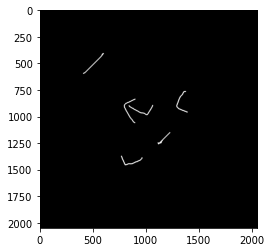

In [114]:
sketch = np.zeros((W, H, 3), dtype=np.uint8)

for segs in segmt_2byn:
    # segs = segs.astype('uint8')
    segs = segs.T
    for pts in segs:    # pts[0]:x, pts[1]:y라 가정
        cv.circle(sketch, (pts[0], pts[1]), 5, (255, 255, 255), -1)
plt.imshow(sketch)

위와 같이 이상한 그림이 그려지는 것을 보아, 아래의 방법이 맞을 것 같음. 우선 계속 진행

In [62]:
# [[x,y],...,[x,y]]
segmt_nby2[0].shape

(79, 2)

In [115]:
(segmt_nby2[0][:10]).T[0]#.squeeze()).T[1]

array([890, 883, 877, 872, 868, 863, 856, 851, 845, 842])

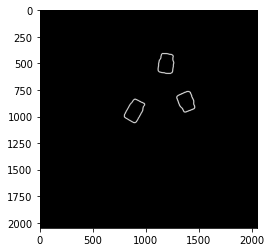

In [121]:
sketch = np.zeros((W, H, 3), dtype=np.uint8)

for segs in segmt_nby2:
    for pts in segs:
        cv.circle(sketch, (pts[0], pts[1]), 5, (255, 255, 255), -1) 
plt.imshow(sketch)

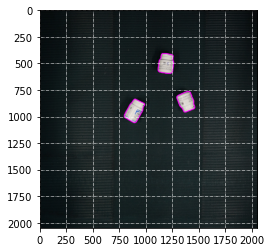

In [140]:
image_0 = cv.imread(trial_img)
image_0 = cv.cvtColor(image_0, cv.COLOR_BGR2RGB)

plt.grid(color="white", linestyle="dashdot", linewidth=.5)
image_0_check = image_0.copy()
for segs in segmt_nby2:
    for pts in segs:
        cv.circle(image_0_check, (pts[0], pts[1]), 5, (255, 0, 255), -1) # cv로 가면 H,W,C인 것처럼 x,y가 아니라 y,x같기도 함(이 부분은 대회끝나고 천천히 확인)
plt.xticks([num for num in range(0, W+1, 250)])        
plt.imshow(image_0_check)

In [19]:
# mask 배열에서 윤곽 좌표 파악
## 현재 대회는 이미 segmentation으로 주어진 값이 있기 때문에 추가적인 함수는 작성하지 않음

# [[x,y],...,[x,y]]
segmt_nby2 = []
for obj in range(len(jsd['annotations'])):
    nbytwo = np.array(jsd['annotations'][obj]['segmentation']).reshape(-1,2)
    segmt_nby2.append(nbytwo)

# 윤곽선만 가져올 경우
def contoursPts(image):
    ''' 
    def "contours" 에 이미지 파일을 입력하기 전, 모든 이미지는 RGB형태로 입력되어야 함(필수는 아닌데, 조건 추가 생성 귀찮..)
    '''
    img = image.copy()
    img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    res, thr    ## 여기서부터 추가 작성해야 함

## way-2 : ./config 에 생성한 함수 사용

```bash
%load "{CONF}/annots_cv.py"
%load "{CONF}/LoadDataset.py"
```

In [20]:
# jn(BASE, NONE, "assets")
"/".join(list(map(lambda x : "".join(x) if x != None else "" ,[None, "/assets", "Train",None])))

'//assets/Train/'

In [21]:
[p for p in "/assets".split('/') if p != ""]

['assets']